In [1]:
##!pip install transformers torch
import praw
import pandas as pd

# Initialize PRAW with your client credentials
reddit = praw.Reddit(client_id='jxUeaoD8b_JZhpd0s2Q-UA',
                     client_secret='JtudGESVw0Bl1eWoybiwnw5-Rfrzvw',
                     user_agent='python:ZeAnalyst:v1.0 (by /u/U_HIT_MY_DOG)')

# List of subreddits you want to scrape
subreddits = ['worldnews']

# Initialize a list to store comment data
comments_data = []

for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    for submission in subreddit.rising(limit=6):  # Adjust the limit as needed
        submission.comments.replace_more(limit=50)
        post_text = submission.selftext
        post_id = submission.id  # Get the ID of the post
        for comment in submission.comments.list():
            # Skip moderator comments
            if comment.distinguished:
                continue
            # Collect comment data
            comments_data.append({
                'comment_id': comment.id,
                'author': str(comment.author),
                'body': comment.body,
                'score': comment.score,
                'subreddit': str(comment.subreddit),
                'post_text': post_text,
                'post_id': post_id  # Add the post ID to the data
            })

# Convert to DataFrame
comments_df = pd.DataFrame(comments_data)


In [2]:
len(comments_df)

3209

In [ ]:
import praw
import pandas as pd

# Initialize PRAW with your client credentials
reddit = praw.Reddit(client_id='jxUeaoD8b_JZhpd0s2Q-UA',
                     client_secret='JtudGESVw0Bl1eWoybiwnw5-Rfrzvw',
                     user_agent='python:ZeAnalyst:v1.0 (by /u/U_HIT_MY_DOG)')

subreddit_name = 'worldnews'  # Replace with your subreddit

# Fetch the top 3 posts from the subreddit
subreddit = reddit.subreddit(subreddit_name)
top_posts = subreddit.hot(limit=3)

print(subreddit.top)
# Initialize a list to store comments
comments_data = []

for post in top_posts:
    post.comments.replace_more(limit=10)  # Load all comments, replace limit with 0 for faster results but less depth
    for comment in post.comments.list():
        comments_data.append({
            'comment_id': comment.id,
            'author': str(comment.author),
            'body': comment.body,
            'score': comment.score,
            'post_id': post.id,
            ##'post_body': post_body,
            'post_title': post.title
        })

# Do something with the comments_data, like printing or saving to a file
for comment in comments_data:
    print(comment)

In [4]:
comments_df = pd.DataFrame(comments_data)

len(comments_df)

1574

In [5]:

from transformers import BertTokenizer, BertForSequenceClassification
import torch

def predict_sentiment(comments):
    # Load pre-trained model and tokenizer
    model_name = "bert-base-uncased"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name)

    # Ensure the model is in evaluation mode
    model.eval()

    # Tokenize and prepare the comments for the model
    inputs = tokenizer(comments, padding=True, truncation=True, max_length=512, return_tensors="pt")

    # Predict sentiment
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Process predictions and return them
    sentiment_predictions = []
    for comment, prediction in zip(comments, predictions):
        sentiment = 'Positive' if prediction[1] > prediction[0] else 'Negative'
        sentiment_predictions.append((comment, sentiment))

    return sentiment_predictions

# Example usage
comments = ["I love this product!", "This is the worst experience ever."]
print(predict_sentiment(comments))


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[('I love this product!', 'Negative'), ('This is the worst experience ever.', 'Negative')]


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

def load_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    return tokenizer, model

def predict_sentiment(comments, model_name):
    tokenizer, model = load_model(model_name)
    model.eval()

    inputs = tokenizer(comments, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    sentiment_predictions = []
    for comment, prediction in zip(comments, predictions):
        sentiment = 'Positive' if prediction[1] > prediction[0] else 'Negative'
        sentiment_predictions.append((comment, sentiment))

    return sentiment_predictions

# Choose the model: 'bert-large-uncased' or 'roberta-large'
model_name = 'bert-large-uncased'  # or 'roberta-large'

# Example comments
comments = ["I love this product!", "This is the worst experience ever."]
print(predict_sentiment(comments, model_name))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[('I love this product!', 'Negative'), ('This is the worst experience ever.', 'Negative')]


In [7]:

# skip
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

def load_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)  # Assuming 5 sentiment categories
    return tokenizer, model

def predict_sentiment(comments, model_name):
    tokenizer, model = load_model(model_name)
    model.eval()

    inputs = tokenizer(comments, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    sentiment_predictions = []
    sentiment_categories = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']  # Example categories
    for comment, prediction in zip(comments, predictions):
        sentiment = sentiment_categories[torch.argmax(prediction).item()]
        sentiment_predictions.append((comment, sentiment))

    return sentiment_predictions

# Choose the model: 'bert-large-uncased' or 'roberta-large'
model_name = 'bert-large-uncased'  # or 'roberta-large'

# Example comments
comments = ["I love this product!", "This is the worst experience ever."]
print(predict_sentiment(comments, model_name))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[('I love this product!', 'Neutral'), ('This is the worst experience ever.', 'Neutral')]


In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

def load_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)  # Assuming 5 sentiment categories
    return tokenizer, model

def predict_sentiment_scores(comments, model_name):
    tokenizer, model = load_model(model_name)
    model.eval()

    inputs = tokenizer(comments, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    sentiment_scores = []
    for comment, prediction in zip(comments, predictions):
        scores = prediction.tolist()  # Convert to list for easier handling
        sentiment_scores.append((comment, scores))

    return sentiment_scores

# Choose the model: 'bert-large-uncased' or 'roberta-large'
model_name = 'roberta-large'  # or 'roberta-large'

# Example comments
comments = ["I love this product!", "This is the worst experience ever."]
print(predict_sentiment_scores(comments, model_name))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[('I love this product!', [0.16806019842624664, 0.1340174823999405, 0.2761925756931305, 0.23975972831249237, 0.18196992576122284]), ('This is the worst experience ever.', [0.16951610147953033, 0.12513665854930878, 0.2836656868457794, 0.2476319670677185, 0.17404964566230774])]


In [9]:
example = "Unfortunately, in India, whenever BJP wins elections, everyone at once starts to proclaim Amit Shah as Chanakya, and Modi as an invincible campaigner. There are hundreds of goof-ups by Modi and Shah, and hundreds of good posts by Congress leaders. Don't fall into the propaganda"
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)


{'roberta_neg': 0.40348825, 'roberta_neu': 0.51117545, 'roberta_pos': 0.08533626}


In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

def load_roberta_model(model_name):
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(model_name)
    return tokenizer, model

def predict_sentiment_roberta(comment, model_name):
    tokenizer, model = load_roberta_model(model_name)
    model.eval()

    # Encode the comment to be compatible with the model
    encoded_input = tokenizer.encode(comment, return_tensors='pt', max_length=512, truncation=True)

    # Generate a response
    with torch.no_grad():
        outputs = model(encoded_input)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Assuming binary classification (positive/negative)
    sentiment = 'Positive' if predictions[0][1] > predictions[0][0] else 'Negative'
    return sentiment

# Example usage
model_name = 'roberta-large'  # or another RoBERTa model variant
comments_df['sentiment'] = comments_df['body'].apply(lambda x: predict_sentiment_roberta(x,model_name))


comments_df.head


In [ ]:
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
from scipy.special import softmax

def print_iterations(func):
    def wrapper(*args, **kwargs):
        wrapper.count += 1
        print(f"Processing iteration {wrapper.count}")
        return func(*args, **kwargs)
    wrapper.count = 0
    return wrapper

def load_roberta_model(model_name):
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)  # Assuming 3 sentiment categories
    return tokenizer, model

@print_iterations
def polarity_scores_roberta(example, model_name):
    tokenizer, model = load_roberta_model(model_name)
    model.eval()
    encoded_text = tokenizer.encode(example, return_tensors='pt', max_length=512, truncation=True)
    output = model(encoded_text)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    
    
    return scores_dict

# Define the model name
model_name = 'roberta-base'  # or another RoBERTa model variant

# Load your DataFrame here
# comments_df = pd.read_csv('your_file.csv')  # Example for loading DataFrame from a CSV file

# Apply the function to the 'body' column
comments_df['sentiment'] = comments_df['body'].apply(lambda x: polarity_scores_roberta(x, model_name))

# Display the DataFrame with the new 'sentiment' column
print(comments_df.head())


In [ ]:
pd.set_option('display.max_colwidth', 1000)

print(comments_df['sentiment'])

In [13]:
sentiment_df = comments_df['sentiment'].apply(pd.Series)


In [14]:
comments_df = pd.concat([comments_df.drop(['sentiment'], axis=1), sentiment_df], axis=1)


In [15]:
comments_df['roberta_neg'] = comments_df['roberta_neg'] * -1 
comments_df

# sorted_df = comments_df.sort_values(by=['Column1', 'Column2'], ascending=[False, False])



,comment_id,author,body,score,post_id,post_title,roberta_neg,roberta_neu,roberta_pos
0,kzimnf3,CrimsonLancet,">Iran, Russia and China have engaged in an unholy alliance to undermine and destabilize the US, Israel and the free world. We must act decisively — Congress must pass aid to Israel, Ukraine, and Taiwan AND the Senate must pass the SHIP Act.\n\nhttps://twitter.com/RepMikeLawler/status/1779259375971930582\n\n>Ukraine is under attack by Iranian drones on a nightly basis. They better pass aid to Ukraine along with aid to Israel. Outrageous if they don’t.\n\nhttps://twitter.com/MaxBoot/status/1779296818431512884",85,1c3kilc,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 781, Part 1 (Thread #927)",-0.369335,0.260845,0.369820
1,kzi33cr,FanPractical9683,"Ukrainian pilots effectively attack Russian command post in Luhansk\n\n""Having held the pause [needed to keep relevant information from the Russians – ed], I would like to thank the pilots of the Air Force for a successful, and most importantly, an effective strike on an enemy facility in Luhansk Oblast on 13 April 2024.\n\nhttps://www.pravda.com.ua/eng/news/2024/04/14/7451161/",69,1c3kilc,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 781, Part 1 (Thread #927)",-0.299671,0.310322,0.390007
2,kzi4mpm,CrimsonLancet,">FYI, the drones that Iran attacked Israel with overnight are the same Iranian drones that Tehran provides to Russia and are used to attack Ukraine on an almost daily basis. Ukrainians call them “flying lawnmowers” and “mopeds” because of their ominous humming, as they fly low and slow before diving and exploding into their targets.\n>\n>Those of us in Ukraine know all too well what Iran's Shahed-136 kamikaze drones are capable of, having endured attacks with 1,000s of them for 1.5 years.\n>\n>Here's our @FT story from Oct. 2022, on the Iranian drones and their capabilities. Since then, Tehran and Russia have improved the design so the drones fly faster and are harder to shoot down. https://ft.com/content/5bd20e77-d368-49dd-a7bd-bcb93fc4594b\n\nhttps://twitter.com/ChristopherJM/status/1779388554247827942",53,1c3kilc,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 781, Part 1 (Thread #927)",-0.362492,0.318288,0.319221
3,kzieaiw,thisiscotty,"""Commander-in-Chief of the Ukrainian Forces, Oleksandr Syrskyi, stated that the Russian military leadership has set the task for its troops to capture Chasiv Yar by May 9. Measures to provide brigades with more ammo, drones and EW-means were taken.""\n\n\n\nhttps://twitter.com/NOELreports/status/1779439257116921861?t=El6NNfk5BGnEzAoYR--TRg&s=19",56,1c3kilc,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 781, Part 1 (Thread #927)",-0.261473,0.419097,0.319430
4,kzixe43,stirly80,"Russian serviceman involved with transport and evacuation describes on his Telegram the Robotyne foothold as an area of extremely intensive fighting that is very dangerous due to Ukrainian firepower which, as he says, isn't lacking. \n\nHe then puts a spotlight on the Russian TV which paints an opposite picture to what he sees.\n\nhttps://twitter.com/wartranslated/status/1779482247881515202?t=SNkvqfK4TkCsb6FFh_3UJQ&s=19",57,1c3kilc,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 781, Part 1 (Thread #927)",-0.260979,0.341426,0.397595
...,...,...,...,...,...,...,...,...,...
1569,kzlyh30,riko_rikochet,"""Nationalizing utilities"" has been happening on a local scale for a while now so a national program isn't so far-fetched and gun reform is a pretty moderate position. But you're right, we can't have left-ward progress when at any point, half or more of the country and by extension Congress, is Republican. And then you have Republicans in sheep's clothing like Sinema. That's why the focus has been undoing things like gerrymandering or years of neglecting control of local politics. \n\nAnd on the flip side, I'd lived in California for 30 years and it's had a Democratic super-majority, and the state is far 

In [18]:
import plotly.express as px
import pandas as pd


fig = px.scatter(comments_df, x='roberta_neg', y='roberta_pos', color='roberta_neu'
                )
# fig.update_traces(hovertemplate='%{customdata[0]}')

fig.show()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

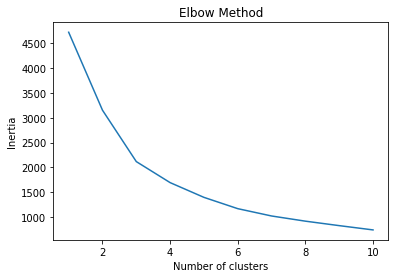

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



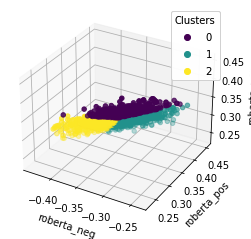

In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd


# Preprocessing: Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(comments_df[['roberta_neg', 'roberta_pos', 'roberta_neu']])

# Choosing the number of clusters (k) - Elbow Method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Apply K-Means clustering
k = 3  # Replace with the number of clusters you choose
kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
comments_df['Cluster'] = kmeans.labels_

# 3D Scatter plot to visualize the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(comments_df['roberta_neg'], comments_df['roberta_pos'], comments_df['roberta_neu'], c=comments_df['Cluster'], cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_xlabel('roberta_neg')
ax.set_ylabel('roberta_pos')
ax.set_zlabel('roberta_neu')
plt.show()
